In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)

Image ID: 163939
**************************************************
Categories: ['tv', 'dining table', 'cup', 'keyboard', 'spoon', 'book']
Super Categories: ['electronic', 'furniture', 'kitchen', 'indoor']
**************************************************
Q:what color are the noodles
A:white
Q:is the noodles in liquid
A:yes
Q:is the cup big
A:medium
Q:does the cup have a handle
A:yes
Q:is the computer on
A:i think so
Q:what color is the computer
A:i can only see the bottom of the screen and the keyboard, so silver
Q:is the computer a laptop
A:nope
Q:is there a person
A:nope
Q:is there a chair
A:can't see that much of the scene
Q:is there a desk
A:yes

**************************************************


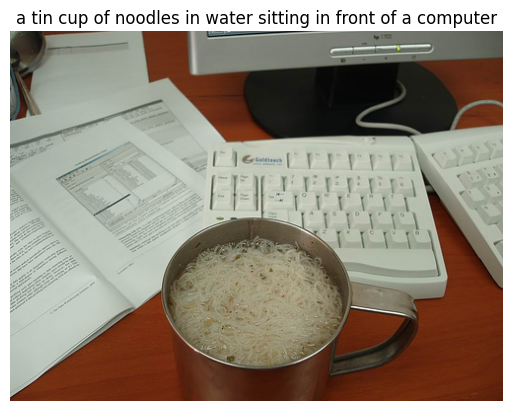

person CLIP feature similarity: 0.2169189453125
animal CLIP feature similarity: 0.226318359375
vehicle CLIP feature similarity: 0.2169189453125
outdoor CLIP feature similarity: 0.2054443359375
accessory CLIP feature similarity: 0.239013671875
sports CLIP feature similarity: 0.2274169921875
kitchen CLIP feature similarity: 0.251953125
food CLIP feature similarity: 0.253173828125
furniture CLIP feature similarity: 0.21630859375
electronic CLIP feature similarity: 0.229248046875
appliance CLIP feature similarity: 0.234375
indoor CLIP feature similarity: 0.197021484375


In [3]:
# Showing one example
# TODO: Add VSNR for cosine similarity
data_loader = loaders.DataLoader(data_source = "qa")
df_table = data_loader.load_dialogue_df()
k = 5
data_loader.showing_example(k)
data_loader.show_clip_similarity(k, df_table, model, preprocess)

In [4]:
ood_category = ['vehicle']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]

df_table['OOD'] = df_table['supercategories'].apply(lambda x: 0 if any(item in x for item in ind_category) else 1)
df_table['OOD'].value_counts()

OOD
0    9425
1     490
Name: count, dtype: int64

In [5]:
clip_features = data_loader.load_clip_features(df_table, model, preprocess, verbose = 1)

In [6]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategories']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [8]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

if data_loader.data_source == "qa":
    df_table['image_id'] = df_table['image_id'].apply(lambda x: f"COCO_train2014_{int(x):012d}")

def calculate_image_score(row):
    image_path = f"{data_loader.data_image_dir}/{row['image_id']}.jpg"
    image = Image.open(image_path)
    preprocessed_image = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(preprocessed_image)

    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text = 'Category ' + categories
        text_tokens = clip.tokenize([text]).to(device)  
        with torch.no_grad():
            text_features = model.encode_text(text_tokens)
        cosine_sim_current = F.cosine_similarity(image_features, text_features).item()
        cosine_sim += np.exp(cosine_sim_current*10)
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)

    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_image_score, axis=1))

  0%|          | 0/9915 [00:00<?, ?it/s]

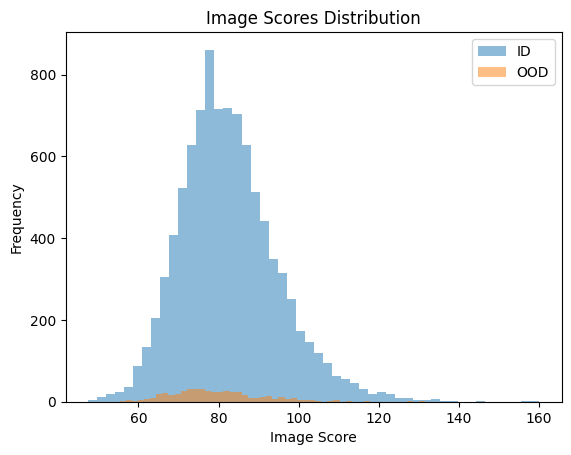

In [21]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['image_score']
non_ood_scores = df_table[df_table['OOD'] == 0]['image_score']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Image Scores Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

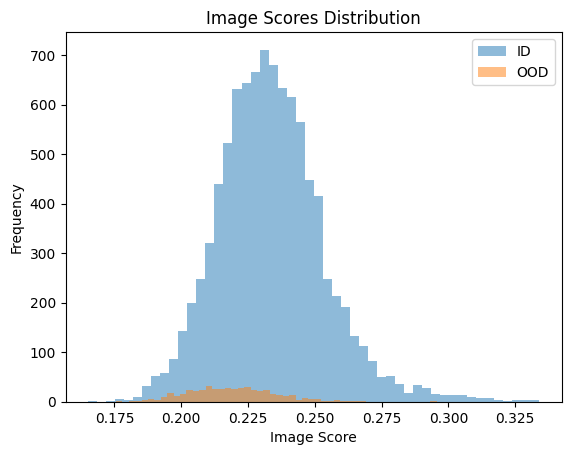

In [22]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['image_score_max']
non_ood_scores = df_table[df_table['OOD'] == 0]['image_score_max']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Image Scores Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

In [31]:
ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score_max'].values, 0.8)

[-0.2956543  -0.29541016 -0.29516602 -0.29467773 -0.29443359 -0.29418945
 -0.29394531 -0.29370117 -0.29345703 -0.29321289 -0.29296875 -0.29223633
 -0.29199219 -0.29174805 -0.29150391 -0.29125977 -0.29101562 -0.29077148
 -0.29052734 -0.2902832  -0.29003906 -0.28979492 -0.28955078 -0.28930664
 -0.2890625  -0.28881836 -0.28857422 -0.28833008 -0.28808594 -0.2878418
 -0.28759766 -0.28735352 -0.28710938 -0.28686523 -0.28662109 -0.28637695
 -0.28613281 -0.28588867 -0.28540039 -0.28515625 -0.28466797 -0.28442383
 -0.28369141 -0.28344727 -0.28320312 -0.28295898 -0.28271484 -0.2824707
 -0.28222656 -0.28198242 -0.28173828 -0.28149414 -0.28100586 -0.28076172
 -0.28051758 -0.28027344 -0.2800293  -0.27978516 -0.27954102 -0.27929688
 -0.27905273 -0.27880859 -0.27856445 -0.27832031 -0.27807617 -0.27783203
 -0.27758789 -0.27734375 -0.27709961 -0.27685547 -0.27661133 -0.27636719
 -0.27612305 -0.27587891 -0.27563477 -0.27539062 -0.27514648 -0.27490234
 -0.2746582  -0.27441406 -0.27416992 -0.27392578 -0.2

0.4880636604774536

In [32]:
ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score'].values, 0.8)

[-131.53164965 -131.29539723 -130.96144814 ...  -48.30483237  -47.6956869
  -47.492131  ]
[1.         0.99795918 0.99795918 ... 0.         0.         0.        ]
[9.98620690e-01 9.98620690e-01 9.98514589e-01 ... 2.12201592e-04
 1.06100796e-04 0.00000000e+00]


0.7149071618037135

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

class MultiLabelNN(nn.Module):
    def __init__(self, input_size=512, output_size=11):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256) 
        self.fc2 = nn.Linear(256, 128) 
        self.fc3 = nn.Linear(128, 64) 
        self.fc4 = nn.Linear(64, output_size)    
        self.relu = nn.ReLU()           
        self.sigmoid = nn.Sigmoid()    

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))  
        return x


In [34]:
df_ind = df_table[df_table['OOD'] == 0]
df_ind_train = df_ind.sample(frac=0.8, random_state=0)
df_ind_train = df_ind_train.loc[np.sort(df_ind_train.index)]
df_test = df_table.drop(df_ind_train.index)

In [35]:
X_train = clip_features.loc[df_ind_train.index]
X_test = clip_features.loc[df_test.index]

In [36]:
def evaluate(model, data_loader, loss_function):
    model.eval()  
    total_loss = 0
    total_accuracy = 0
    total_samples = 0

    with torch.no_grad():  
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
            predictions = outputs > 0.5 
            total_accuracy += (predictions == labels.byte()).all(dim=1).float().mean().item()
            total_samples += 1

    average_loss = total_loss / total_samples
    average_accuracy = total_accuracy / total_samples

    return average_loss, average_accuracy

In [42]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 32
EPOCH = 20

X_train_tensor = torch.tensor(X_train.values).float() 
Y_train_tensor = torch.tensor(np.vstack(df_ind_train['encoded_label'].values)).float()

X_test_tensor = torch.tensor(X_test.values).float()
Y_test_tensor = torch.tensor(np.vstack(df_test['encoded_label'].values)).float()

dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

model = MultiLabelNN()
loss_function = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

for epoch in range(EPOCH):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

    average_loss, average_accuracy = evaluate(model, train_loader, loss_function)
    test_loss, test_accuracy = evaluate(model, test_loader, loss_function)

    print(f'Epoch {epoch+1}, Train Loss: {average_loss:.4f}, Train Accuracy: {average_accuracy:.4f}')
    print(f'Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch 1, Train Loss: 0.3528, Train Accuracy: 0.1877
Epoch 1, Test Loss: 0.3215, Test Accuracy: 0.1629
Epoch 2, Train Loss: 0.2473, Train Accuracy: 0.3521
Epoch 2, Test Loss: 0.2369, Test Accuracy: 0.2935
Epoch 3, Train Loss: 0.2135, Train Accuracy: 0.4093
Epoch 3, Test Loss: 0.2096, Test Accuracy: 0.3558
Epoch 4, Train Loss: 0.1949, Train Accuracy: 0.4426
Epoch 4, Test Loss: 0.1913, Test Accuracy: 0.3933
Epoch 5, Train Loss: 0.1826, Train Accuracy: 0.4717
Epoch 5, Test Loss: 0.1875, Test Accuracy: 0.4013
Epoch 6, Train Loss: 0.1731, Train Accuracy: 0.4993
Epoch 6, Test Loss: 0.1760, Test Accuracy: 0.4455
Epoch 7, Train Loss: 0.1644, Train Accuracy: 0.5191
Epoch 7, Test Loss: 0.1694, Test Accuracy: 0.4640
Epoch 8, Train Loss: 0.1582, Train Accuracy: 0.5335
Epoch 8, Test Loss: 0.1625, Test Accuracy: 0.4758
Epoch 9, Train Loss: 0.1533, Train Accuracy: 0.5460
Epoch 9, Test Loss: 0.1628, Test Accuracy: 0.4749
Epoch 10, Train Loss: 0.1494, Train Accuracy: 0.5571
Epoch 10, Test Loss: 0.1641, 

In [43]:
model.eval()  
with torch.no_grad():  
    for inputs, labels in test_loader:
        outputs = model(inputs)

In [50]:
outputs_energy.shape

torch.Size([2375, 11])

In [61]:
outputs_energy = -np.log(1+outputs/(1-outputs))
outputs_energy_sum = outputs_energy.sum(axis=1)
df_test['energy_sum'] = outputs_energy_sum
df_test['energy_max'] = outputs_energy.min(axis=1).values.numpy()

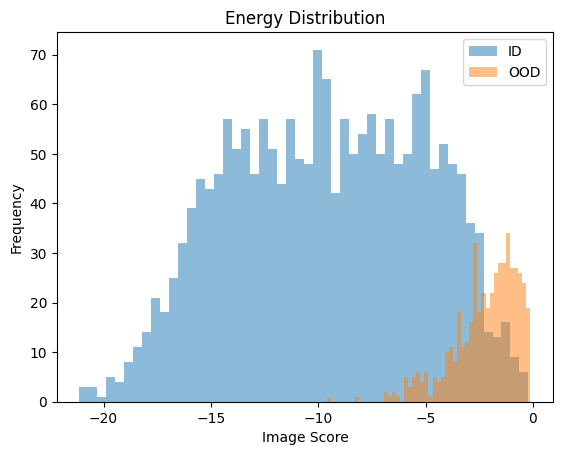

In [62]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1]['energy_sum']
non_ood_scores = df_test[df_test['OOD'] == 0]['energy_sum']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

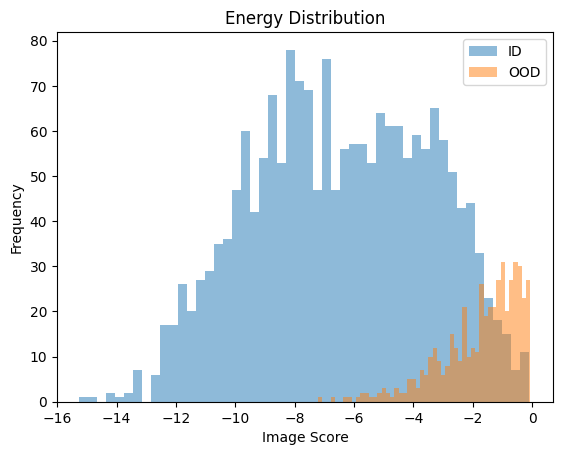

In [63]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1]['energy_max']
non_ood_scores = df_test[df_test['OOD'] == 0]['energy_max']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

In [64]:
ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_sum'].values, 0.8)

[-9.612148   -9.608151   -9.595728   ... -0.16570199 -0.14341977
 -0.12301223]
[1.         0.99795918 0.99795918 ... 0.00408163 0.00204082 0.        ]
[0.50238727 0.50238727 0.50185676 ... 0.         0.         0.        ]


0.08169761273209548

In [65]:
ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_max'].values, 0.8)

[-7.222333   -7.2103224  -7.2053337  ... -0.07861397 -0.06792303
 -0.06129982]
[1.         0.99795918 0.99795918 ... 0.00408163 0.00204082 0.        ]
[0.57824934 0.57824934 0.57771883 ... 0.         0.         0.        ]


0.12413793103448276